In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from random import randint
import glob

In [2]:
def get_image_names(base_name):
    score_file_name = f'../setup/{base_name}.png'
    mask_file_name = f'../setup/{base_name}_mask.png'
    return score_file_name, mask_file_name

def get_images(base_name):
    score_file_name, mask_file_name = get_image_names(base_name)
    mask_image = Image.open(mask_file_name).convert('L')
    mask_image = Image.eval(mask_image, lambda x: x*10) # saturate the mask
    score_image = Image.open(score_file_name)
    background = Image.new('RGBA', score_image.size, (255,255,255))
    score_image = Image.alpha_composite(background,score_image)
    score_image = score_image.convert('L')
    return score_image, mask_image

def dice_image_name(dest,prefix,count):
    return os.path.join(dest,"%s_%03d.png"%(prefix,count))

# dice up images regularly & save, but if score is completely white, then we only need to save one of those.  
# make a 2nd pass with random offsets
def dice_image_pairs(image0, image1, 
                     dest_dir, 
                     image0_prefix, image1_prefix, 
                     offset=(0,0), dice_pixels=64):
    image_count = 0
    if not os.path.isdir(dest_dir):
        print("ERROR: directory %s does not exist"%(dest_dir))
        return
    assert(image0.size == image1.size)
    saved_all_white_image = False
    all_white_images = []
    for y in range(0, image0.size[1], dice_pixels):
        for x in range(0, image0.size[0], dice_pixels):
            xx = x + offset[0]
            yy = y + offset[1]
            xx1 = xx + dice_pixels
            yy1 = yy + dice_pixels
            crop0 = image0.crop((xx,yy,xx1,yy1))
            is_all_white_image = crop0.getextrema() == (255,255)
            if ((not is_all_white_image) or
                (is_all_white_image and (not saved_all_white_image))):
                crop1 = image1.crop((xx,yy,xx1,yy1))
                #print("dump",xx,yy,is_all_white_image,saved_all_white_image)
                crop0.save(dice_image_name(dest_dir, image0_prefix, image_count))
                crop1.save(dice_image_name(dest_dir, image1_prefix, image_count))
                if is_all_white_image:
                    all_white_images = [dice_image_name(dest_dir, image0_prefix, image_count), 
                                        dice_image_name(dest_dir, image1_prefix, image_count)]
                    saved_all_white_image = True
                image_count += 1
    #print(f"diced 2x{image_count} images.")
    return all_white_images

In [3]:
!mkdir -p data/train
!mkdir -p data/test
!mkdir -p data/valid

In [4]:
# create a new set of images
!rm data/train/*png data/test/*png data/valid/*png

In [5]:
all_white_pairs = []
#for base_name in ['chromatic', 'chromatic_piano', 'gen_one', 'gen_two', 'twinkle']:
# FIXME dropping chromatic_piano temporarily
for base_name in ['chromatic', 'gen_one', 'gen_two', 'twinkle']:
    score_image, mask_image = get_images(base_name)
    for i in range(20):
        if i == 0:
            offset = (0,0)
        else:
            offset = (randint(-32,32), randint(-32,32))
        all_white_pairs += dice_image_pairs(score_image,mask_image, 
                                            "data/train",
                                            "diced_score_"+base_name+str(i),
                                            "diced_mask_"+base_name+str(i),
                                            offset)
# okay, there are enough of these, that I'm not worrying about train/test/valid set
len(all_white_pairs)

156

In [6]:
all_files  = glob.glob('data/train/diced_*.png')
num_images = len(all_files)
num_valid  = int(0.2*num_images)
num_test   = int(0.2*num_images)
num_train  = num_images-num_valid-num_test
print("total=%d train=%d valid=%d test=%d"%(num_images,num_train,num_valid,num_test))
# shuffle the files & then put them into new spots on the tree
# BUT, make sure to move mask & score files 
mask_files  = glob.glob('data/train/diced_mask_*.png')
mask_files  = np.random.permutation(mask_files)
for i in range(num_valid//2): 
    old_file = mask_files[i]
    new_file = old_file.replace("train","valid")
    os.rename(old_file, new_file)
    old_file = mask_files[i].replace("mask_","score_")
    new_file = old_file.replace("train","valid")
    os.rename(old_file, new_file)
for i in range(num_valid//2,num_valid//2+num_test//2): 
    old_file = mask_files[i]
    new_file = old_file.replace("train","test")
    os.rename(old_file, new_file)
    old_file = mask_files[i].replace("mask_","score_")
    new_file = old_file.replace("train","test")
    os.rename(old_file, new_file)


total=20158 train=12096 valid=4031 test=4031


In [7]:
!ls data/train/ | wc -l
!ls data/valid/ | wc -l
!ls data/test/  | wc -l

12098
4030
4030


More random code below...

In [40]:
!ls data/train/diced_*_gen_two2_03*.png

data/train/diced_mask_gen_two2_030.png	data/train/diced_score_gen_two2_030.png
data/train/diced_mask_gen_two2_031.png	data/train/diced_score_gen_two2_031.png
data/train/diced_mask_gen_two2_032.png	data/train/diced_score_gen_two2_032.png
data/train/diced_mask_gen_two2_034.png	data/train/diced_score_gen_two2_034.png
data/train/diced_mask_gen_two2_036.png	data/train/diced_score_gen_two2_036.png
data/train/diced_mask_gen_two2_037.png	data/train/diced_score_gen_two2_037.png
data/train/diced_mask_gen_two2_039.png	data/train/diced_score_gen_two2_039.png


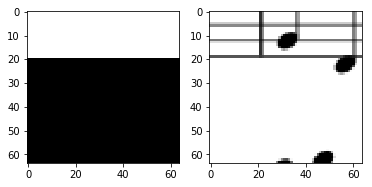

In [45]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(np.asarray(Image.open('data/train/diced_mask_gen_two2_036.png')),cmap='gray')
axs[1].imshow(np.asarray(Image.open('data/train/diced_score_gen_two2_036.png')),cmap='gray')
plt.show()

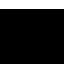

In [43]:
Image.open('data/train/diced_mask_chromatic2_020.png')

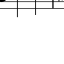

In [44]:
Image.open('data/train/diced_score_chromatic2_020.png')